模型选择这部分其实谈的就是验证集、训练集、欠拟合过拟合啥的，没什么特别重要的，主要是之前弄清楚过了

下面是一个多项式拟合的例子，来帮助理解过拟合、欠拟合

In [7]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [9]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.8279],
         [-0.1974]]),
 tensor([[ 1.0000e+00, -8.2791e-01,  3.4272e-01, -9.4580e-02,  1.9576e-02,
          -3.2414e-03,  4.4727e-04, -5.2899e-05,  5.4745e-06, -5.0360e-07,
           4.1693e-08, -3.1380e-09,  2.1650e-10, -1.3788e-11,  8.1537e-13,
          -4.5003e-14,  2.3287e-15, -1.1341e-16,  5.2162e-18, -2.2729e-19],
         [ 1.0000e+00, -1.9741e-01,  1.9485e-02, -1.2822e-03,  6.3277e-05,
          -2.4983e-06,  8.2196e-08, -2.3180e-09,  5.7199e-11, -1.2546e-12,
           2.4767e-14, -4.4448e-16,  7.3119e-18, -1.1103e-19,  1.5656e-21,
          -2.0604e-23,  2.5422e-25, -2.9520e-27,  3.2375e-29, -3.3637e-31]]),
 tensor([2.4129, 4.5897]))

In [10]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [11]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

正常训练

weight: [[ 4.986204   1.2069713 -3.3949354  5.586842 ]]


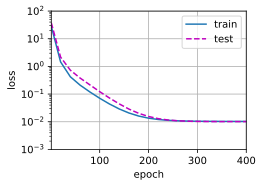

In [12]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

欠拟合

weight: [[3.074579 4.150815]]


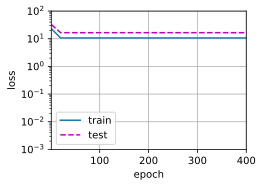

In [13]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

过拟合

weight: [[ 4.9730415   1.2567661  -3.3446233   5.2666345  -0.07210154  1.0201641
  -0.04034031 -0.03679085 -0.16838169 -0.09637962 -0.11300361 -0.2153873
   0.14942665 -0.1433319   0.19705954 -0.04895278 -0.0340437  -0.11605815
   0.07188195 -0.0575728 ]]


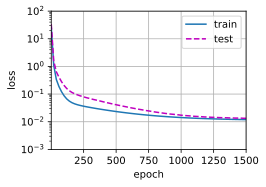

In [14]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

这一节确实没啥好讲的